In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mini_yolov3.model import YOLO
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_target
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes, count_model_parameters, draw_grid
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = SVHNDataset(split="train", image_size=32)
# train_dataset = Subset(train_dataset, range(12, 13))

In [4]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

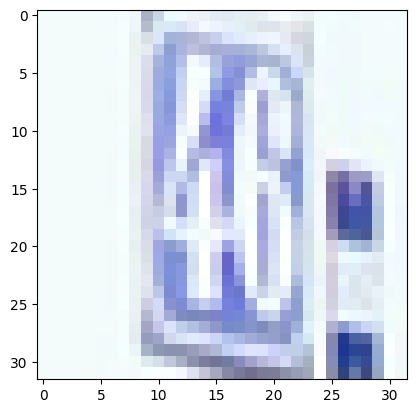

In [5]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

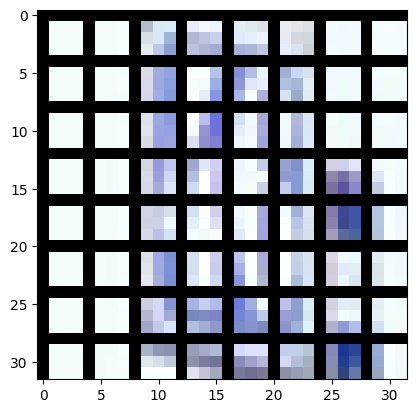

In [6]:
plt.imshow(draw_grid(train_dataset[0]["image"], 32//8))

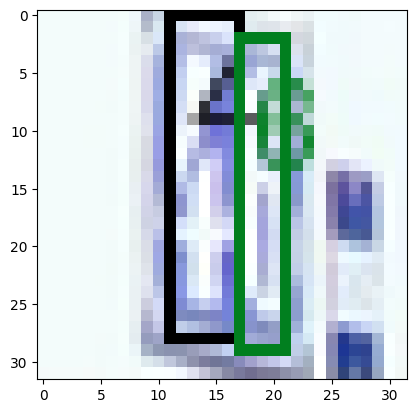

In [7]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [8]:
train_dataset_ = Subset(train_dataset, range(0, 2))

In [9]:
import json

In [48]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment.json", "r"))
model = YOLO(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset_,
    num_epochs=100,
    lr=1e-4,
    batch_size=32,
    log_detections=False,
    lambda_coord=5.0,
    lambda_noobj=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 100/100 [00:12<00:00,  8.33it/s, class_loss=2.33e-5, coord_loss=1.96e-5, loss=0.0247, noobj_loss=0.00126, obj_conf_loss=0.0234] 


[3.5315804481506348,
 2.67364501953125,
 2.121382236480713,
 1.6835906505584717,
 1.3496943712234497,
 1.1078081130981445,
 0.9414401650428772,
 0.8378395438194275,
 0.7780176997184753,
 0.7495860457420349,
 0.7414301037788391,
 0.7411767244338989,
 0.741151750087738,
 0.735753059387207,
 0.721082329750061,
 0.6966719627380371,
 0.6638665795326233,
 0.6262573003768921,
 0.5857330560684204,
 0.5447778701782227,
 0.5056275129318237,
 0.4693411886692047,
 0.43615230917930603,
 0.4069058299064636,
 0.3819989860057831,
 0.36139026284217834,
 0.3444382846355438,
 0.33011651039123535,
 0.31749263405799866,
 0.30559486150741577,
 0.2933362126350403,
 0.28017324209213257,
 0.265916109085083,
 0.2510622441768646,
 0.2361767739057541,
 0.22186820209026337,
 0.2085731476545334,
 0.19675356149673462,
 0.1865673065185547,
 0.17795439064502716,
 0.17055761814117432,
 0.16391021013259888,
 0.15765969455242157,
 0.15157122910022736,
 0.14557316899299622,
 0.13968530297279358,
 0.13387873768806458,
 0.1

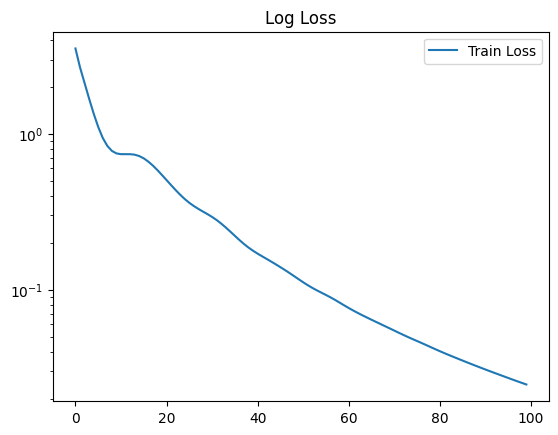

In [30]:
trainer.train()

In [49]:
count_model_parameters(model)

959072

In [31]:
dataloader = DataLoader(train_dataset_, batch_size=10, shuffle=False, collate_fn=collate_fn)
batch = next(iter(dataloader))

In [32]:
batch

{'images': tensor([[[[0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9569, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           ...,
           [0.9529, 0.9529, 0.9529,  ..., 0.5882, 0.9765, 0.9569],
           [0.9529, 0.9529, 0.9529,  ..., 0.5804, 0.9608, 0.9490],
           [0.9608, 0.9608, 0.9608,  ..., 0.5922, 0.9725, 0.9490]],
 
          [[0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9882, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           ...,
           [0.9882, 0.9882, 0.9882,  ..., 0.6745, 1.0000, 0.9725],
           [0.9882, 0.9882, 0.9882,  ..., 0.6667, 1.0000, 0.9765],
           [0.9804, 0.9843, 0.9843,  ..., 0.6549, 1.0000, 0.9725]],
 
          [[0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
           [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9961, 0.9922],
           [0.

In [40]:
i = 1

In [41]:
output = model.inference(
    batch["images"],
    confidence_threshold=0.5,
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.4480, 0.4515, 0.1898, 0.8385],
          [0.6030, 0.4944, 0.1334, 0.8373]]),
  'confidence': tensor([0.9685, 0.9595]),
  'labels': tensor([4, 6]),
  'scores': tensor([0.9592, 0.9454])},
 {'bboxes': tensor([[0.4379, 0.4930, 0.1915, 0.7021],
          [0.5855, 0.5315, 0.1546, 0.7107],
          [0.3450, 0.4680, 0.1789, 0.3792]]),
  'confidence': tensor([0.9853, 0.9824, 0.6505]),
  'labels': tensor([7, 1, 7]),
  'scores': tensor([0.9499, 0.9666, 0.9499])}]

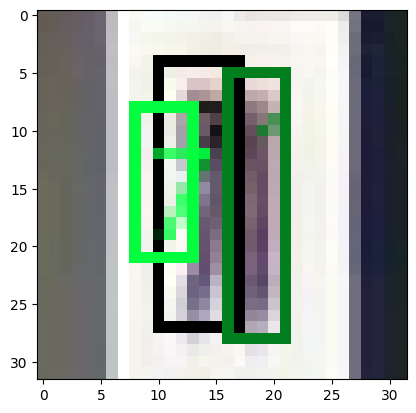

In [42]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

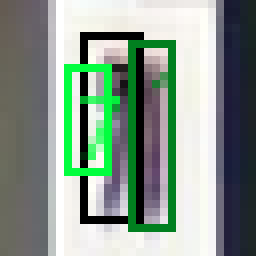

In [43]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [39]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 0.875,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 0.875,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.875,
 'mar_10': 0.875,
 'mar_100': 0.875,
 'mar_small': 0.875,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}

In [325]:
torch.distributed.is_available()

True